## Recuperación de Información
# Práctica 3.3 &mdash; Búsqueda Web y Recomendación - Sistemas de Recomendación
### Autores: *Óscar Calvet, Enrique Ernesto de Alvear Doñate*

# 3.  Parte 3

En esta práctica se usará un dataset (dividido en entrenamiento y test) que se obtendrá de la siguiente manera, una vez que hayáis rellenado vuestros gustos por las películas que se indican en la siguiente hoja de cálculo:
https://docs.google.com/spreadsheets/d/1YmCY-T0ByZRXz8DpaFyieGfsS2jvxsprZr5dsSh8mpE/edit?usp=sharing

Una vez completo, en las pestañas *ratings_training* y *ratings_test* se encontrarán los datos (tripletas <usuario, item, rating>) a utilizar en el resto de la práctica.

Observación: usamos DataFrames por comodidad, pero implementaciones más eficientes podrían hacer uso de las [matrices dispersas](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) de SciPy u otras estructuras de datos que consideréis convenientes.

In [ ]:
import pandas as pd

SHEET_ID = '1YmCY-T0ByZRXz8DpaFyieGfsS2jvxsprZr5dsSh8mpE'
SHEET_NAME = 'ratings_training'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df_training = pd.read_csv(url)
print(df_training.head())
SHEET_NAME = 'ratings_test'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df_testing = pd.read_csv(url)
print(df_testing.head())

   user  item  rating
0     0    18     4.0
1     0    74     4.0
2     0    62     4.0
3     0    47     4.0
4     0    11     3.0
   user  item  rating
0     0   140     4.0
1     0   104     4.0
2     0   123     3.0
3     0   145     3.5
4     0    63     4.0


## 3.1 Implementar algoritmo de recomendación

Aplicar un algoritmo de filtrado colaborativo basado en memoria para generar recomendaciones de películas para cada estudiante. La estrategia a usar será a elección de cada estudiante, teniendo en cuenta las consideraciones vistas en clase. Aplicarlo utilizando las puntuaciones de entrenamiento como base para recomendar películas del conjunto de test, y observar el nivel de acierto (visualmente, comparando puntuación real de test y predicción del recomendador).

Se implementa CF KNN basado en items con coseno ajustado.

In [ ]:
##Generamos los ratings medios de cada usuario:
import numpy as np
rating_medio = df_training.groupby(['user'])['rating'].mean()

##Calcular similitudes:
def sim(x,y):
  xset = df_training[df_training.item == x].set_index('user').sub(rating_medio, axis = 0).dropna().drop(columns = ['item'])
  yset = df_training[df_training.item == y].set_index('user').sub(rating_medio, axis = 0).dropna().drop(columns = ['item'])
  mul = xset.mul(yset, axis = 0).dropna()
  res = float(np.sum(mul)/np.sqrt(np.sum(xset**2)*np.sum(yset**2)))
  return 0 if np.isnan(res) else res

#Generamos la matriz de similitudes:
sim_matrix = np.asarray([[sim(x+1,y+1) for y in range(df_training.item.nunique())] for x in range(df_training.item.nunique())])

In [ ]:
def cfknn(matrix, data, k=40):
  res = []
  for _, row in data.iterrows():
    sims = matrix[int(row['item'])-1,:]
    sims_indexed = pd.DataFrame(sims, index=[i for i in range(1,df_training['item'].nunique()+1)], columns = ['rating'])
    #Interseccion
    uitems = df_training[(df_training['user'] == row['user'])]['item']
    sims_indexed = sims_indexed.loc[uitems]
    #Nos quedamos con los k mayores y positivos
    sims_indexed = sims_indexed[sims_indexed['rating']>0].sort_values(by = 'rating', ascending=False).iloc[:k]
    #sacamos el ranking
    ranks = df_training[(df_training['user'] == row['user']) & (df_training['item'].isin(sims_indexed.index))].drop(columns = ['user']).set_index('item')
    c = 1/np.sum(sims_indexed)
    res.append(np.sum(ranks*sims_indexed)*c)
  return np.asarray(res)


In [ ]:
res = df_testing.copy()
res['prediction'] = cfknn(sim_matrix, df_testing)
res

,user,item,rating,prediction
0,0,140,4.0,4.051838
1,0,104,4.0,3.691390
2,0,123,3.0,3.868638
3,0,145,3.5,3.793314
4,0,63,4.0,3.638810
...,...,...,...,...
327,9,101,1.0,2.706417
328,9,115,1.0,3.232908
329,9,76,3.0,2.724800
330,9,51,4.0,2.679643


In [ ]:
res = df_training.copy()
res['prediction'] = cfknn(sim_matrix, df_training)
res

,user,item,rating,prediction
0,0,18,4.0,3.715607
1,0,74,4.0,3.985634
2,0,62,4.0,3.994620
3,0,47,4.0,3.702706
4,0,11,3.0,3.668515
...,...,...,...,...
1295,9,121,3.0,3.145639
1296,9,79,4.0,3.721145
1297,9,77,4.0,4.078572
1298,9,8,1.0,1.333912


## 3.2 Evaluación

Calcular el MAE y RMSE de las recomendaciones producidas. Contrastar los resultados (MAE y RMSE) de dos estrategias diferentes de recomendación (o de la misma estrategia con diferentes parámetros).

Calcular P@N (precisión) y R@N (recall) de las recomendaciones producidas a distintos N, considerando como relevantes aquellos ítems con un rating mayor que 3 en test. Para ello, tened en cuenta que habrá que predecir una puntuación (para cada usuario) usando todos los ítems del sistema excepto aquellos que ya ha visto en entrenamiento, ordenando dichas puntuaciones para generar el ranking.

Comenzamos con MAE y RMSE.

In [ ]:
mae = np.mean(np.abs(res['rating'] - res['prediction']))
print('El MAE obtenido para coseno ajustado ha sido: ' + str(mae))

rmse = np.sqrt(np.mean((res['rating'] - res['prediction'])**2))
print('El RMSE obtenido para coseno ajustado ha sido: ' + str(rmse))

El MAE obtenido para coseno ajustado ha sido: 0.36787833647041857
El RMSE obtenido para coseno ajustado ha sido: 0.488315136674431


Pasamos a calcular P@N y R@N:

In [ ]:
#Conjunto de items no presente en el dataset para cada usuario
recomend = pd.DataFrame(columns = ['user', 'item'])
all_items = set([i for i in df_training['item'].unique()])
for user in df_training['user'].unique():
  seen = df_training[df_training['user'] == user]['item']
  not_seen = all_items.difference(seen)
  for val in not_seen:
    recomend.loc[len(recomend)] = [user, val]


In [ ]:
#Obtenemos las valoraciones del modelo
val_not_seen = cfknn(sim_matrix, recomend, k=40)
recomend['ranking_pred'] = val_not_seen

In [ ]:
#Sacamos la p

def prec_rank(recomend, n, col = 'ranking_pred'):
  precs = []
  for user in recomend['user'].unique():
    top_n = recomend[recomend['user'] == user].sort_values(by=col, ascending=False).iloc[:n]['item']
    relevants = df_testing[(df_testing['user'] == user) & (df_testing['rating'] > 3)]['item']
    precs.append(len(set(top_n).intersection(set(relevants)))/n)
  return np.mean(precs)

#sacamos la r

def rec_rank(recomend, n, col = 'ranking_pred'):
  recs = []
  for user in recomend['user'].unique():
    top_n = recomend[recomend['user'] == user].sort_values(by=col, ascending=False).iloc[:n]['item']
    relevants = df_testing[(df_testing['user'] == user) & (df_testing['rating'] > 3)]['item']
    recs.append(len(set(top_n).intersection(set(relevants)))/len(relevants))
  return np.mean(recs)

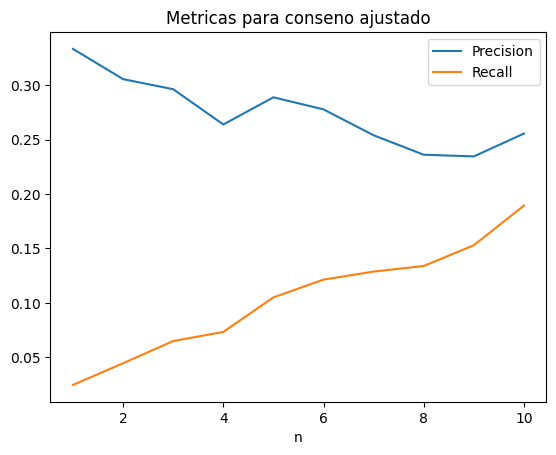

In [ ]:
#Mostrar valores
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,11)], [prec_rank(recomend,n) for n in range(1,11)], label = 'Precision')
plt.plot([i for i in range(1,11)], [rec_rank(recomend,n) for n in range(1,11)], label = 'Recall')
plt.legend();
plt.xlabel('n')
plt.title('Metricas para conseno ajustado');

Repetir todo para otro tipo de recomendación:

Implementamos basado en usuario mediante correlación de Pearson.

In [ ]:
##Generamos los ratings medios de cada usuario:
import numpy as np
rating_medio = df_training.groupby(['user'])['rating'].mean()

##Calcular similitudes entre users:
def sim_user(u,v):
  #items en común
  xset = df_training[df_training.user == u].set_index('item').drop(columns = ['user']) - rating_medio[u]
  yset = df_training[df_training.user == v].set_index('item').drop(columns = ['user']) - rating_medio[v]
  mul = xset.mul(yset, axis = 0).dropna()
  res = float(np.sum(mul)/np.sqrt(np.sum(xset**2)*np.sum(yset**2)))
  return 0 if np.isnan(res) else res

#Generamos la matriz de similitudes:
sim_user_matrix = np.asarray([[sim_user(x,y) for y in range(df_training.user.nunique())] for x in range(df_training.user.nunique())])

In [ ]:
def cfknn_user(matrix, data, k=40):
  res = []
  for _, row in data.iterrows():
    sims = matrix[int(row['user']),:]
    sims_indexed = pd.DataFrame(sims, index=[i for i in range(0,df_training['user'].nunique())], columns = ['rating'])
    #Interseccion
    uitems = df_training[(df_training['item'] == row['item'])]['user']
    sims_indexed = sims_indexed.loc[uitems]
    #Nos quedamos con los k mayores y positivos
    sims_indexed = sims_indexed[sims_indexed['rating']>0].sort_values(by = 'rating', ascending=False).iloc[:k]
    #sacamos el ranking
    ranks = df_training[(df_training['item'] == row['item']) & (df_training['user'].isin(sims_indexed.index))].drop(columns = ['item']).set_index('user')
    c = 1/np.sum(sims_indexed)
    res.append(rating_medio[row['user']]+np.sum((ranks.sub(rating_medio, axis = 0).dropna())*sims_indexed)*c)
  return np.asarray(res)

In [ ]:
res_users = df_testing.copy()
res_users['prediction'] = cfknn_user(sim_user_matrix, df_testing)
res_users

,user,item,rating,prediction
0,0,140,4.0,4.532236
1,0,104,4.0,2.814222
2,0,123,3.0,3.715860
3,0,145,3.5,3.865780
4,0,63,4.0,3.500666
...,...,...,...,...
327,9,101,1.0,2.304806
328,9,115,1.0,3.137262
329,9,76,3.0,1.585192
330,9,51,4.0,4.539264


In [ ]:
mae = np.mean(np.abs(res_users['rating'] - res_users['prediction']))
print('El MAE obtenido para pearson con usuarios ha sido: ' + str(mae))

rmse = np.sqrt(np.mean((res_users['rating'] - res_users['prediction'])**2))
print('El RMSE obtenido para pearson con usuarios ha sido: ' + str(rmse))

El MAE obtenido para pearson con usuarios ha sido: 0.7674076765801382
El RMSE obtenido para pearson con usuarios ha sido: 0.9635742758164156


In [ ]:
#Conjunto de items no presente en el dataset para cada usuario
recomend = pd.DataFrame(columns = ['user', 'item'])
all_items = set([i for i in df_training['item'].unique()])
for user in df_training['user'].unique():
  seen = df_training[df_training['user'] == user]['item']
  not_seen = all_items.difference(seen)
  for val in not_seen:
    recomend.loc[len(recomend)] = [user, val]


In [ ]:
#Obtenemos las valoraciones del modelo
val_not_seen = cfknn_user(sim_user_matrix, recomend, k=40)
recomend['ranking_pred'] = val_not_seen

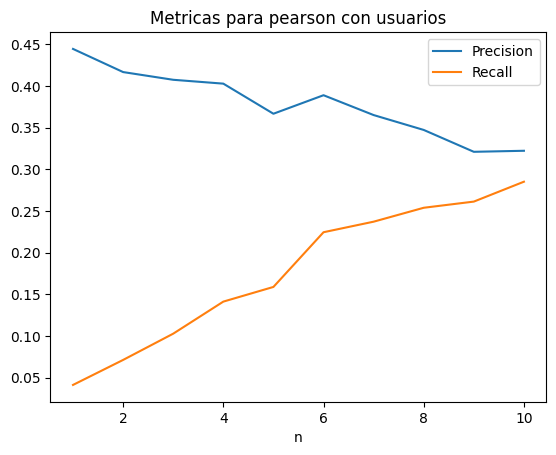

In [ ]:
plt.plot([i for i in range(1,11)], [prec_rank(recomend,n) for n in range(1,11)], label = 'Precision')
plt.plot([i for i in range(1,11)], [rec_rank(recomend,n) for n in range(1,11)], label = 'Recall')
plt.legend();
plt.xlabel('n')
plt.title('Metricas para pearson con usuarios');

## 3.3 Informe

Escribir un informe explicando los resultados y las técnicas concretas aplicadas.

Se ha implementado cfKNN para coseno y Pearson, utilizando las fórmulas de similitud:
- coseno:
\begin{equation}
  sim(u, v) = cos(r(u),r(v)) = \frac{ \sum_{x\in I} r(u,x) \cdot r(v,x)}{\sqrt{\sum_{x\in I} r(u,x)^2 \cdot \sum_{x\in I}  r(v,x)^2}}
\end{equation}

- Pearson:

\begin{equation}
  sim(u,v) = \frac{\sum_{x\in I}(r(u,x)-\bar r(u))\cdot (r(v,x)-\bar r(v))}{\sqrt{\sum_{x\in I}(r(u,x)-\bar r(u))^2 \cdot \sum_{x\in I}(r(v,x)-\bar r(v))^2}}
\end{equation}

Tenemos en cuenta primero que solo consideramos los valores para los cuales conocemos el ranking, no utilizamos como indicador que el usuario no haya valorado una película. Segundo a la hora de recuperar las similitudes, todos los valores con similitud $\leq 0$ no son considerados.

A continuación, se crea la matriz de similitud, con la cual se ha procedido a hacer KNN con cada una de las matrices. Y se evaluan los resultados de las recomendaciones utilizando MSE y RMSE, comparando ambos métodos estudiando también la evolución de la precisión y el recall con respecto al número de vecinos máximo con similitud mayor a $0$ , utilizando los rankings con puntuación mayor que $3$ como relevantes.

Se puede ver que para la similitud coseno se consigue un menor error tanto en MSE como en RMSE en comparación con la similitud Pearson, pero en cambio se obtiene una precisión mayor por norma general con Pearson, para la detección de relevantes en el conjunto de test.



## Opcional 3.A

Utilizar librerías (por ejemplo, Surprise o LightFM en Python) sobre los mismos datos para generar las recomendaciones y comparar con los resultados anteriores. Contrastar los valores de MAE y RMSE de las diferentes pruebas. Para cualquier duda o dificultad con este apartado consultar con el profesor.

In [ ]:
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162728 sha256=fc3b03a28fd7897c716c42ddf4e028b6f7e4d39060c62dafe4cbf9c2d8b2ebff
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


La librería surprise no implementa coseno ajustado así que solo comparamos con pearson basado en usuarios.

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader

# To use user-based adjusted cosine similarity
sim_options = {
    "name": "pearson",
    "user_based": True,  # Compute  similarities between users
}
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_training[["user", "item", "rating"]], reader)

In [ ]:
trainingSet = data.build_full_trainset()
algo.fit(trainingSet)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
data_test = Dataset.load_from_df(df_testing[["user", "item", "rating"]], reader)

Evaluamos el dataset de prueba:

In [ ]:
testset = [data_test.df.loc[i].to_list() for i in range(len(data_test.df))]
results = algo.test(testset)

Comparamos en tabla los resultados:

In [ ]:
sur_model_res = [elem.est for elem in results]
sur_model_res = np.asarray(sur_model_res)
res_users['rating_surprise'] = sur_model_res
res_users

,user,item,rating,prediction,rating_surprise
0,0,140,4.0,4.532236,4.558596
1,0,104,4.0,2.814222,2.812226
2,0,123,3.0,3.715860,3.714299
3,0,145,3.5,3.865780,3.923590
4,0,63,4.0,3.500666,3.547804
...,...,...,...,...,...
327,9,101,1.0,2.304806,2.305729
328,9,115,1.0,3.137262,3.004491
329,9,76,3.0,1.585192,1.691118
330,9,51,4.0,4.539264,4.552446


Mostramos el MAE y el RSME

In [ ]:
from surprise import accuracy
mae_sur = accuracy.mae(results)
print('El MAE obtenido para pearson con usuarios mediante surprise ha sido: ' + str(mae_sur))

rmse_sur = accuracy.rmse(results)
print('El RMSE obtenido para pearson con usuarios mediante surprise ha sido: ' + str(rmse_sur))

MAE:  0.7646
El MAE obtenido para pearson con usuarios mediante surprise ha sido: 0.7646327929730823
RMSE: 0.9674
El RMSE obtenido para pearson con usuarios mediante surprise ha sido: 0.9673954932950887


Y recordamos los obtenidos en el método propio:

In [ ]:
mae = np.mean(np.abs(res_users['rating'] - res_users['prediction']))
print('El MAE obtenido para pearson con usuarios ha sido: ' + str(mae))

rmse = np.sqrt(np.mean((res_users['rating'] - res_users['prediction'])**2))
print('El RMSE obtenido para pearson con usuarios ha sido: ' + str(rmse))

El MAE obtenido para pearson con usuarios ha sido: 0.7674076765801382
El RMSE obtenido para pearson con usuarios ha sido: 0.9635742758164156


En primer lugar se ha instalado el módulo surprise y se ha procesado la matriz de ratings de entrenamiento y una vez realizado esto, se ha entrenado el modelo,obteniendo las predicciones de entrenamiento y test.

Hemos comparado visualmente los resultados obtenidos utilizando el método propio y el de surprise, y pese a que existen diferencias a la hora de comparar el error, las comparaciones entre el MAE y RMSE, ambos métodos clasifican de manera similar.

## Opcional 3.B

Implementar un algoritmo de recomendación mediante factorización de matrices.

Implementamos factorización de matrices utilizando f features y descenso por gradiente. Entrenamos teniendo en cuenta lo siguiente:

-Pretendemos minimizar:
$$
\min_{q*,p*}\sum_{(u,i)\in 𝐾}(r_{ui}-q^t_i⋅p_u)^2 +\lambda(||q_i||^2 +||p_u||^2)
$$
donde
$$
𝐾 = \{(u,i)|r_{ui} \neq 0\}
$$
Es decir $𝐾$ indica el rating de cada item $i$ por parte del usuario $u$. El parámetro $\lambda$ es de regularización del aprendizaje.

-Para realizar descenso por gradiente debemos calcular los errores y sus derivadas:

$$
e_{ui} = r_{ui} -\hat{r}_{ui} = r_{ui} - q^t_ip_u
$$

Tomando derivadas acabamos obteniendo que el valor de $q_i$ y $p_i$ para cada iteración viene dado por:

$$
q_i^{n+1} = q_i^{n} + γ(e_{ui}\cdot p_u - \lambda q_i)
$$
$$
p_u^{n+1} = p_u^{n} + γ(e_{ui}\cdot q_i - \lambda p_u)
$$

Pasamos a implementar el código. Primero debemos generar la matriz de ratings.

In [ ]:
rating_mat = [[0 if df_training[(df_training.user == user) & (df_training.item==item)].empty else
               df_training[(df_training.user == user) & (df_training.item==item)].rating.values[0] for item in range(1,df_training.item.nunique() +1)]
              for user in range(df_training.user.nunique())]
rating_mat = np.asarray(rating_mat)

In [ ]:
rating_mask = np.sign(rating_mat)

Creamos el algoritmo para calcular la factorización

In [ ]:
def matrix_factorization(R, K, steps=1000, gamma=0.0002, lambda_val=0.02, print_loss = False):
    '''
    R: rating matrix (|U|x|I|)
    P: |U| * K (User features matrix)
    Q: |I| * K (Item features matrix)
    K: features
    steps: iterations
    gamma: learning rate
    lambda_val: regularization parameter'''

    #Start by generating random matrices
    U = R.shape[0]
    I = R.shape[1]
    P = np.random.normal(scale = 1/U ,size=(U, K))
    Q = np.random.normal(scale = 1/I ,size=(I, K))
    val_loss, val_prec, val_rec = [], [], []
    score_ = P @ Q.T
    for step in range(steps):
        #Se usa la mascara para solo aprender de las valoraciones conocidas
        mat_err = rating_mat - score_*rating_mask
        grad_item, grad_user = mat_err.T @ P, mat_err @ Q
        P += gamma*(grad_user - lambda_val * P)
        Q += gamma*(grad_item - lambda_val * Q)
        train_err = (mat_err**2).mean()
        score_ = P @ Q.T
        #Validation
        pred = []
        for _, row in df_testing.iterrows():
          pred.append(score_[int(row['user'])][int(row['item'])-1])
        pred = np.asarray(pred)
        pred_mf = df_testing.copy()
        pred_mf['pred_rating'] = pred
        rmse = np.sqrt(np.mean((pred_mf['rating'] - pred_mf['pred_rating'])**2))
        val_prec.append(prec_rank(pred_mf,10, col = 'pred_rating'))
        val_rec.append(rec_rank(pred_mf,10, col = 'pred_rating'))
        val_loss.append(rmse)
        if print_loss:
          print('Epoch: ' + str(step+1) + ' loss: ' + str(train_err) + ' val_error: ' + str(rmse))
    if not print_loss:
      print('Epoch: ' + str(steps) + ' loss: ' + str(train_err)+ ' val_error: ' + str(rmse))
    return P, Q, val_loss, val_prec, val_rec

Ejecutamos utilizando nuestros datos:

In [ ]:
#Elegimos k características por vector
k = 50
nP, nQ, val_loss, val_prec, val_rec = matrix_factorization(rating_mat, k, steps = 1000, print_loss = False)
nR = np.dot(nP, nQ.T)

Epoch: 1000 loss: 0.21482437888458586 val_error: 0.9796536462613153


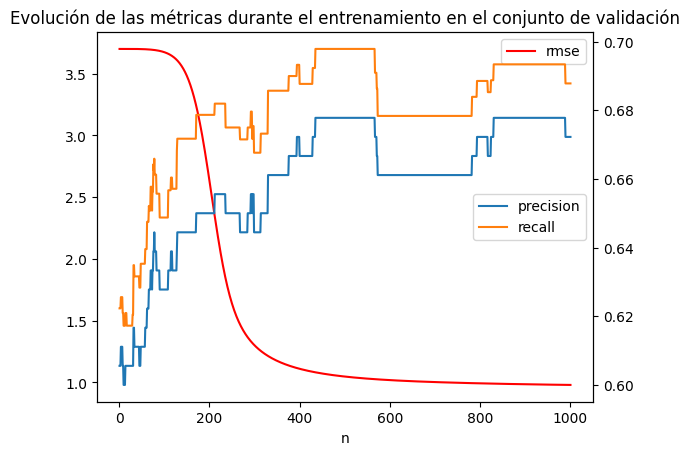

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot([i for i in range(1,1001)], val_loss, label = 'rmse', c='r')
ax1.legend();
ax1.set_xlabel('n')
ax1.set_title('Evolución de las métricas durante el entrenamiento en el conjunto de validación')
ax2 = ax1.twinx()
ax2.plot([i for i in range(1,1001)], val_prec, label = 'precision');
ax2.plot([i for i in range(1,1001)], val_rec, label = 'recall');
ax2.legend(loc = 'center right');

Obtenemos las predicciones:

In [ ]:
pred = []
for _, row in df_testing.iterrows():
  pred.append(nR[int(row['user'])][int(row['item'])-1])
pred = np.asarray(pred)
pred_mf = df_testing.copy()
pred_mf['pred_rating'] = pred

Calculamos métricas:

In [ ]:
mae = np.mean(np.abs(pred_mf['rating'] - pred_mf['pred_rating']))
print('El MAE obtenido para MF ha sido: ' + str(mae))

rmse = np.sqrt(np.mean((pred_mf['rating'] - pred_mf['pred_rating'])**2))
print('El RMSE obtenido para MF ha sido: ' + str(rmse))

print('La precisión obtenida para MF ha sido: ' + str(val_prec[-1]))
print('El recall obtenido para MF ha sido: ' + str(val_rec[-1]))

El MAE obtenido para MF ha sido: 0.7866029164706779
El RMSE obtenido para MF ha sido: 0.9796536462613153
La precisión obtenida para MF ha sido: 0.6722222222222223
El recall obtenido para MF ha sido: 0.6878001628001628


Se ha implementado el método de descomposición de matrices, ignorando los ratings no conocidos y utilizando $k = 50$ como dimensión del embedding, en cada iteración del algoritmo de descenso por gradiente, se ha evaluado el rendimiento en el conjunto de test. Se aprecia una mejora importante de los resultados a partir de la iteración 200. Los resultados obtenidos son buenos con respecto a los clasificadores anteriores aunque presenta un error bastante elevado todavía (es posible que el número de usuarios sea demasiado reducido).

## Opcional 3.C

Implementar un algoritmo basado en contenido (usando los géneros de las películas como atributos).

Procedemos a acceder a la tabla de Excel que contiene el nombre de la película y la url con su ficha en IMDB.

In [ ]:
#Sacamos las urls del excel
import numpy as np
SHEET_NAME = 'ratings_bellogin'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df_urls = pd.read_csv(url)

Realizamos un scrapping sobre cada una de las urls para obtener los géneros de cada película, según la plataforma.

In [ ]:
#Sacamos el genero de cada película
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
generos = []
for url in df_urls['IMDb_url']:
  req = Request(
    url=url,
    headers={'User-Agent': 'Mozilla/5.0'}
  )
  response = urlopen(req)
  page = BeautifulSoup(response, 'lxml')
  genre = page.select_one('div.ipc-chip-list__scroller')
  aux = []
  for genre in genre.contents:
    aux.append(genre.text)
  generos.append(aux)

In [ ]:
#Generamos el dataframe con los generos en one-hot
df_urls['genre'] = generos
df_urls = df_urls.loc[:, ~df_urls.columns.str.contains('^Unnamed')]
df_urls = df_urls.drop(['user', 'rating','IMDb_url','Alejandro Bellogín', 'movie_title'], axis = 1)
df_urls = df_urls.drop(['genre'], axis =1).join(df_urls.genre.str.join('|').str.get_dummies())
df_urls = df_urls.rename(columns={'movie_id' : 'item'})

In [ ]:
#Unimos los datasets
user_movie_df = df_training.merge(df_urls, on = 'item', how='left')

Una vez obtenidos los géneros de cada película, juntamos en una tabla los datos de entrenamiento junto a los géneros de cada películas, éstos últimos en codificación One-hot.

In [ ]:
user_movie_df.head()

,user,item,rating,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War
0,0,18,4.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,0,74,4.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,0,62,4.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,47,4.0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
4,0,11,3.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
#Pasamos a calcular el vector medio de cada usuario:
for col in user_movie_df.columns:
  if col != 'user' and col !='item' and col != 'rating':
    user_movie_df[col] = user_movie_df[col] * user_movie_df['rating']

Para calcular el vector medio de cada usuario, se multiplica el rating de cada usuarioi para cada película por la codificación de su género. Después se calcula la media de cada género y cada usuario.

Para cada usuario obtenemos su vector.

In [ ]:
user_emb = user_movie_df.groupby(['user']).mean().drop(columns=['item', 'rating'])
user_emb = user_emb.div(user_emb.sum(axis=1), axis=0).reset_index()
user_emb.head()

,user,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War
0,0,0.133368,0.136482,0.031655,0.012455,0.099637,0.077841,0.201349,0.021796,0.039440,0.017644,0.003114,0.048262,0.056046,0.060197,0.003114,0.046186,0.011417
1,1,0.116024,0.110345,0.039351,0.012576,0.115619,0.097363,0.233671,0.015822,0.027181,0.009736,0.005274,0.059635,0.057201,0.041785,0.005680,0.043813,0.008925
2,2,0.134417,0.146233,0.063516,0.019202,0.113737,0.069424,0.194978,0.017725,0.062038,0.010340,0.000000,0.011817,0.053176,0.050222,0.000000,0.038405,0.014771
3,3,0.170732,0.151476,0.034660,0.007702,0.101412,0.057766,0.189987,0.017972,0.037227,0.011553,0.000000,0.037227,0.042362,0.077022,0.007702,0.046213,0.008986
4,4,0.163889,0.169444,0.047917,0.013194,0.093056,0.056944,0.177083,0.011111,0.059722,0.006944,0.003472,0.032639,0.045833,0.085417,0.003472,0.023611,0.006250


Una vez generados estos embeddings recomendamos películas (Aproximamos rating multiplicando similitud por 5).

In [ ]:
res_users = df_testing.copy()

In [ ]:
preds = []
for _, row in res_users.iterrows():
  movie_car = df_urls[df_urls.item == row['item']].drop(columns=['item'])
  movie_car = np.asarray(movie_car)
  movie_car = movie_car/np.linalg.norm(movie_car)
  user_car = user_emb[user_emb.user == row['user']].drop(columns=['user'])
  user_car = np.asarray(user_car)
  user_car = user_car/np.linalg.norm(user_car)
  preds.append((movie_car @ user_car.T)[0][0]*5)
res_users['prediction'] = preds

Para cada película no evaluada por un usuario se genera su vector de géneros One-hot, se normaliza, y se compara con el vector de embedding del usuario, obteniendo la similitud coseno, se multiplica por 5 para obtener el rating aproximado.

In [ ]:
mae = np.mean(np.abs(res_users['rating'] - res_users['prediction']))
print('El MAE obtenido para pearson con usuarios ha sido: ' + str(mae))

rmse = np.sqrt(np.mean((res_users['rating'] - res_users['prediction'])**2))
print('El RMSE obtenido para pearson con usuarios ha sido: ' + str(rmse))

El MAE obtenido para pearson con usuarios ha sido: 1.3194684791380307
El RMSE obtenido para pearson con usuarios ha sido: 1.5780795874575049


In [ ]:
#Conjunto de items no presente en el dataset para cada usuario
recomend = pd.DataFrame(columns = ['user', 'item'])
all_items = set([i for i in df_training['item'].unique()])
for user in df_training['user'].unique():
  seen = df_training[df_training['user'] == user]['item']
  not_seen = all_items.difference(seen)
  for val in not_seen:
    recomend.loc[len(recomend)] = [user, val]
preds = []
for _, row in recomend.iterrows():
  movie_car = df_urls[df_urls.item == row['item']].drop(columns=['item'])
  movie_car = np.asarray(movie_car)
  movie_car = movie_car/np.linalg.norm(movie_car)
  user_car = user_emb[user_emb.user == row['user']].drop(columns=['user'])
  user_car = np.asarray(user_car)
  user_car = user_car/np.linalg.norm(user_car)
  preds.append((movie_car @ user_car.T)[0][0]*5)
recomend['prediction'] = preds

In [ ]:
recomend['ranking_pred'] = preds

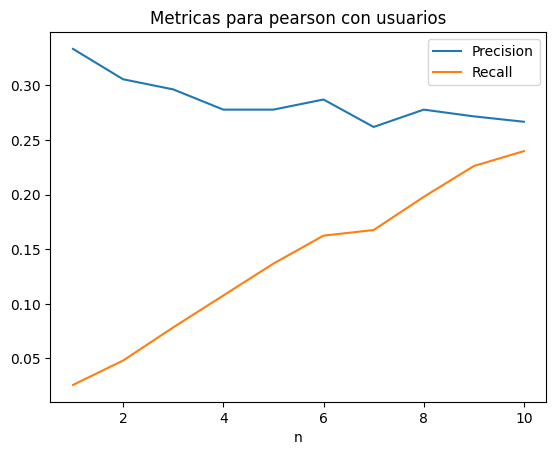

In [ ]:
plt.plot([i for i in range(1,11)], [prec_rank(recomend,n) for n in range(1,11)], label = 'Precision')
plt.plot([i for i in range(1,11)], [rec_rank(recomend,n) for n in range(1,11)], label = 'Recall')
plt.legend();
plt.xlabel('n')
plt.title('Metricas para pearson con usuarios');

Se evalua con el conjunto de testeo y observamos que el método tiene un error superior a 1 en ambas métricas, así que no es muy buen recomendador. Esto puede ser debido a que IMDB tiene un máximo de 3 géneros por película, por lo que es posible que no figuren todos los géneros correspondientes a cada película. También es posible que las preferencias de los usuarios no estén centradas únicamente en esta información.

## Opcional 3.D

Repetir alguno de los ejercicios con alguna colección de prueba (p.e., [MovieLens](https://grouplens.org/datasets/movielens/)).

Decidimos utilizar MovieLens de 100k por las restricciones en tiempo de computación.

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2024-04-01 13:59:50--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  11.7MB/s    in 0.5s    

2024-04-01 13:59:51 (11.7 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
movies = pd.read_table('./ml-1m/ratings.dat', sep="::", header=None)
movies = movies.rename(columns={0: 'user', 1: 'item', 2: 'rating'})
#movie_training['user'] = movie_training['user']-1
movies = movies.drop(columns = [3])
movies.head()

<ipython-input-44-62faef22b0d2>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_table('./ml-1m/ratings.dat', sep="::", header=None)


,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


Procedemos a calcular las similitudes y los rankings, usamos surprise porque el tiempo de computación de nuestros algoritmos es demasiado extenso.Usamos KNN basado en usuarios con correlación de Pearson.

In [ ]:
# To use user-based adjusted cosine similarity
sim_options = {
    "name": "pearson",
    "user_based": True,  # Compute  similarities between users
}
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies[["user", "item", "rating"]], reader)

In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
results = algo.test(testset)

In [ ]:
from surprise import accuracy
mae_sur = accuracy.mae(results)
print('El MAE obtenido para pearson con usuarios mediante surprise ha sido: ' + str(mae_sur))

rmse_sur = accuracy.rmse(results)
print('El RMSE obtenido para pearson con usuarios mediante surprise ha sido: ' + str(rmse_sur))

MAE:  0.7260
El MAE obtenido para pearson con usuarios mediante surprise ha sido: 0.7259830281212232
RMSE: 0.9217
El RMSE obtenido para pearson con usuarios mediante surprise ha sido: 0.9217423538085885


Se ha repetido la pipeline en el método surprise con método basado en usuarios, con correlación de Pearson y con el dataset de Movielens con 1000000 de ratings.
Se puede ver que el resultado es razonable y el error cometido es inferior al 1 en ambas métricas. Los resultados no son comparables con los anteriores porque son datasets distintos.